In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

### Reading in LDA topic dataframes...

In [2]:
comb = {}
for i in range(1966,2006,5):
    print "getting dataframe %d..." % i
    comb[i] = pd.read_csv("/Users/Luke/Documents/cs109/project/comb%d.csv" % i)
    comb[i]['date'] = pd.to_datetime(comb[i]['date'])
    comb[i]['year'] = comb[i]['date'].dt.year
    comb[i]['month'] = comb[i]['date'].dt.month

getting dataframe 1966...
getting dataframe 1971...
getting dataframe 1976...
getting dataframe 1981...
getting dataframe 1986...
getting dataframe 1991...
getting dataframe 1996...
getting dataframe 2001...

/Users/Luke/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Luke/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Issues with 2006 dataframe, NaT values in date column

A small issue was encountered with the 2006 dataset in the `dates` column. It is possible there was an erorr in downloading the file on this computer, as some of us did not encounter this issue, though reuploading and redownloading the csv did not change the outcome. Eventually it was discovered that two documents in the dataframe out of 45020 were missing values in the `dates` column. These values were dropped. Given their size relative to the full dataset, the potential loss of information is negligible.

In [14]:
comb[2006] = pd.read_csv("/Users/Luke/Documents/cs109/project/comb2006.csv")

In [15]:
s = comb[2006]['date'].convert_objects(convert_dates='coerce')
s[pd.isnull(s)]

/Users/Luke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


27827   NaT
32989   NaT
Name: date, dtype: datetime64[ns]

In [16]:
comb[2006].shape

(45020, 58)

In [17]:
comb[2006] = comb[2006].drop(27827)
comb[2006] = comb[2006].drop(32989)
comb[2006].shape

(45018, 58)

In [18]:
comb[2011] = pd.read_csv("/Users/Luke/Documents/cs109/project/comb2011.csv")

In [19]:
for i in [2006,2011]:
    comb[i]['date'] = pd.to_datetime(comb[i]['date'])
    comb[i]['year'] = comb[i]['date'].dt.year
    comb[i]['month'] = comb[i]['date'].dt.month

### AIDs trends over time, as modeled by LDA

An initial look at the topic *AIDs* (acquired immunodeficiency syndrome) within our data. This topic was prevalent only in the years 1986-2001. Though the word *AIDs* did appear after 2001, it was buried by noise from other topics. Thus, the following analyses consider only data from the aforementioned time interval.

We chose to study this topic further for multiple reasons. First, it was a clear label that we easily determined in the topic check. Second, we hypothesized that there would be noticeable time trends for *AIDs* that might appear in the data. Third, *AIDs* is a unique and specific topic within the field of public health, allowing us to compare our results from LDA against scientific articles in peer-reviewed journals using PubMed's API.

The Y axis of the graph below is the probability of a specific topic (*AIDs*) generated by LDA. The X axis is the date of publication for these articles, divided into quartiles to reduce noise. The quartiles provide the mean topic probability within that timeframe as default. We then concatenated the data together to provide a smoothe line for the entire interval of interest.

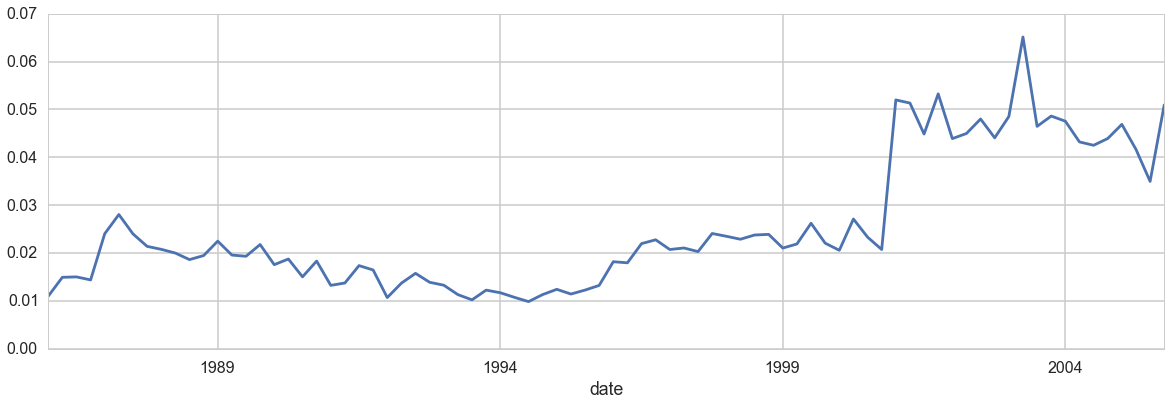

In [21]:
cont86 = comb[1986].set_index('date').resample('Q')['Topic5']
cont91 = comb[1991].set_index('date').resample('Q')['Topic55']
work = cont86.combine_first(cont91)
cont96 = comb[1996].set_index('date').resample('Q')['Topic47']
work = work.combine_first(cont96)
cont01 = comb[2001].set_index('date').resample('Q')['Topic3']
work = work.combine_first(cont01)
plt.figure(figsize=(20,6)); work.plot();

Topics were chosen based on probabilities generated by LDA and logical reasoning by teammembers. AIDs did not present as a topic between 1966-1985, or 2006-2015.

### Pubmed data retrieval

The following formulas were created to retrieve data from PubMed's API. We used code provided publicly on github to assist in this retrieval. Full discussion of these methods is available at the following URL: https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/# and the author's github: https://gist.github.com/bonzanini/5a4c39e4c02502a8451d. 

First we install the Biopython package in the terminal: `pip install biopython`

Next we import the `Entrez` module from Biopython. 

In [22]:
import requests
import time
import json
from Bio import Entrez

The search function takes `query` (the topic of interest - string), `retmax` (the maximum number of articles to retrieve from PubMed - integer), `mindate` (the starting date for the search - integer), `maxdate` (the ending date for the search - integer), and `reldate` (when interested in articles from the last N days - integer). We also provide an email to the function in case the Entrez database needs to reach out to us for making excess numbers of calls. This function is the primary call to PubMed.

In [48]:
def search(query, retmax=False, mindate=False, maxdate=False, reldate=False): 
    Entrez.email = 'lukeam2929@gmail.com'
    handle = Entrez.esearch(db='pubmed', 
                            sort='relevance', 
                            retmax=retmax,
                            retmode='xml',
                            datetype='pdat',
                            #reldate=reldate,
                            mindate=mindate,
                            maxdate=maxdate,
                            term=query)
    results = Entrez.read(handle)
    return results

The function `fetch_details` combines the results from `search` over an idlist that exists in the search call.

In [49]:
def fetch_details(id_list):
    ids = ','.join(id_list)
    Entrez.email = 'your.email@example.com'
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    results = Entrez.read(handle)
    return results

The function `pubmeddf` combines the previously defined functions and outputs a pandas dataframe with the following columns: `PMID` - the id assigned to the article by PubMed, `Title` - the title of the publication, `Day`, `Month`, `Year`, and `Abstract` - the abstract of the publication, if available. In most cases, the dates for articles were publication dates. However, this information was not available for all articles, so we used the `DateCreated` parameter instead. `DateCreated` is the date PubMed assigned a PMID to the article and made it available for search in the databse. We reasoned this was justifiable given its relative closeness to the publication dates (typically a few months after publication), and that the distribution of articles using `DateCreated` would not differ substantially between our 5 year intervals.

In [50]:
def pubmeddf(term, retmax, mindate, maxdate):
    results = search(term, retmax, mindate, maxdate) # add reldate if needed
    id_list = results['IdList']
    papers = fetch_details(id_list)
    all_papers = []
    for paper in papers:
        d = {}
        try:
            d['PMID'] = int(paper['MedlineCitation']['PMID'])
            d['Title'] = paper['MedlineCitation']['Article']['ArticleTitle']
            if len(paper['MedlineCitation']['Article']['ArticleDate']) > 0:
                d['Month'] = paper['MedlineCitation']['Article']['ArticleDate'][0]['Month']
                d['Day'] = paper['MedlineCitation']['Article']['ArticleDate'][0]['Day']
                d['Year'] = paper['MedlineCitation']['Article']['ArticleDate'][0]['Year']
            else:
                d['Month'] = paper['MedlineCitation']['DateCreated']['Month']
                d['Day'] =paper['MedlineCitation']['DateCreated']['Day']
                d['Year'] = paper['MedlineCitation']['DateCreated']['Year']
            try:
                d['Abstract'] = paper['MedlineCitation']['Article']['Abstract']['AbstractText'][0]
            except:
                d['Abstract'] = None

            all_papers.append(d)
        except:
            continue

    return pd.DataFrame(all_papers)

We called on the function separately for each 5 year interval to emulate our process from LDA. We attempted to retrieve 10000 articles for each call, as this is the maximum amount PubMed allows in a single call. We also opted to use the term *HIV* instead of *AIDs* as it is more concise and represenative within medical literature.

In [51]:
pmdf = {}

In [60]:
pmdf[1986] = pubmeddf("HIV", "10000", 1986, 1990)

In [52]:
pmdf[1991] = pubmeddf("HIV", "10000", 1991, 1995)

In [56]:
pmdf[1996] = pubmeddf("HIV", "10000", 1996, 2000)

In [57]:
pmdf[2001] = pubmeddf("HIV", "10000", 2001, 2006)

In [58]:
pmdf[2006] = pubmeddf("HIV", "10000", 2006, 2011)

In [59]:
pmdf[2011] = pubmeddf("HIV", "10000", 2001, 2015)

In [46]:
#print(json.dumps(papers[20], indent=2, separators=(',', ':')))

Printing the shape for each dataframe we notice that some articles were lost in the calls. This was either due to a lack of PMID or article title for the article.

In [70]:
for k in range(1986,2016,5):
    print pmdf[k].shape

(9999, 6)
(9999, 6)
(9997, 6)
(10000, 6)
(9996, 6)
(9999, 6)


Next we subset the data only to include articles published in their respective interval, and performed general housekeeping. Initial looks at the data revealed that the search returned some dates outside of the range of interest (e.g. the dataset 1986-1990 might have a few articles with dates in the late 90s), so we removed them for analysis. 

In [101]:
pmdf_subset = {}
for year in range(1986,2016,5):
    pmdf[year]['date'] = pmdf[year][['Year','Month','Day']].apply(lambda x: '-'.join(x), axis=1)
    pmdf[year]['date'] = pd.to_datetime(pmdf[year]['date'])
    pmdf[year]['Year'] = pmdf[year]['Year'].astype(int)
    pmdf_subset[year] = pmdf[year][pmdf[year]['Year']<year+5]

Here we generate frequencies of articles for every month in the data, and add these frequencies as a new column at the end of the subset dataframe (from above). Next, we create an additional column that scales the frequencies down to the LDA probabilities in order to compare trends on a single graph. Note, this scaling was done approximately and does not represent any quantity of interest. Further discussion is made in graph interpretation below.

In [412]:
for year in range(1986,2016,5):
    pmdf_subset[year]['counts'] = pmdf_subset[year].groupby(['Year','Month'])['Day'].transform('count')
    pmdf_subset[year]['scaled'] = pmdf_subset[year]['counts']/200

/Users/Luke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/Luke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


We reassess the shape of our datasets. Loss of articles was minimal in the subsetting process, though something interesting happened in the 2006-2010 dataset. Though further investigation is needed into the Entrez database search process, it is possible that publication dates were not provided for these articles thus `DateCreated` was used instead, which may fall outside of the search bounds. Nevertheless, as our LDA data was restricted between 1986-2001, this curiosity could be ignored for analysis.

In [133]:
for k in range(1986,2016,5):
    print pmdf_subset[k].shape

(8720, 9)
(9142, 9)
(9367, 9)
(7932, 9)
(3428, 9)
(9999, 9)


In [134]:
pmdf_subset[1986].dtypes

Abstract            object
Day                 object
Month               object
PMID                 int64
Title               object
Year                 int64
date        datetime64[ns]
counts               int64
scaled             float64
dtype: object

### Plotting

We define fonts for consistency in plotting.

In [348]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
font2 = {'family': 'serif',
         'color':  'black',
         'weight': 'normal',
         'size': 16,
         }
font3 = {'family': 'serif',
         'color':  'black',
         'weight': 'normal',
         'size': 20,
         }
font4 = {'family': 'serif',
         'color':  'black',
         'weight': 'normal',
         'size': 12,
         }

The following code plots our LDA topic probabilities against PubMed article frequencies. The Y axis is topic probability for New York Times articles averaged over yearly quartiles (i.e. 4 months), and is scaled article frequency for PubMed articles also averaged over yearly quartiles. We concatenated data from different time intervals/dataframes as suggested previously. As such, the data are comparable by trend and "spikes" only (thus the removal of the Y axis labels). 

There are a few notable insights from this plot. First and foremost, we see that NYT reported on AIDs frequently and early in the *AIDs* crisis, while it took researchers more time to publish in peer-reviewed journals. Next, we see that trends between the two publishers were fairly parallel during the 90s as *AIDs* remained prevalent in the public and academic mindsets. Third, we see a spike in NYT reporting on AIDs in the early 2000s, most likely reflecting the AIDs crisis developing in Southern Africa. This spike does not seem to alter publication frequency however, which continues at its current pace. Perhaps this is due to research being reliant on grants, such that funding was being delegated to issues more prevalent in researchers' home countries (i.e. the war on terror, Iraq). Further investigation into this topic is necessary, but our exploratory analyses may provide new hypotheses. 

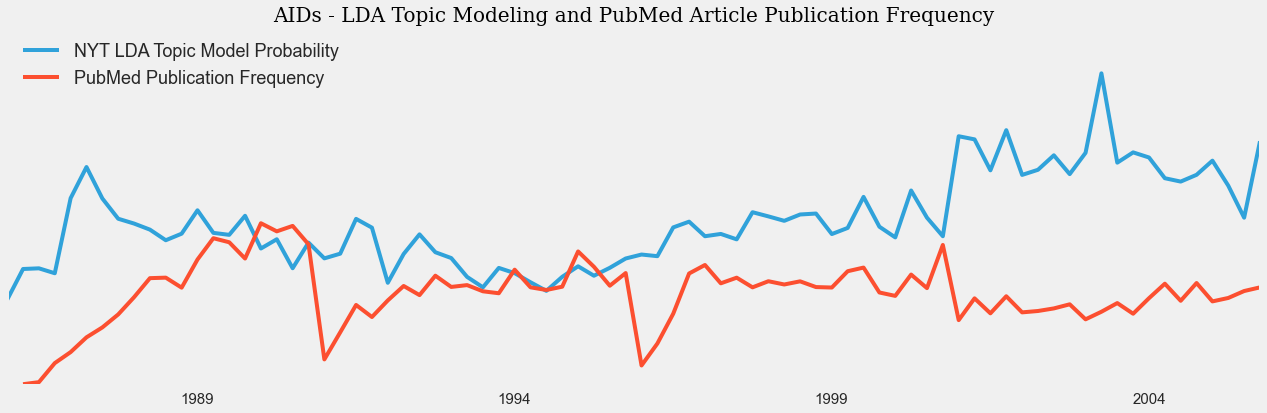

In [414]:
cont86 = comb[1986].set_index('date').resample('Q')['Topic5']*65
cont91 = comb[1991].set_index('date').resample('Q')['Topic55']*80
work = cont86.combine_first(cont91)
cont96 = comb[1996].set_index('date').resample('Q')['Topic47']*60
work = work.combine_first(cont96)
cont01 = comb[2001].set_index('date').resample('Q')['Topic3']*40
work = work.combine_first(cont01)

pub86 = pmdf_subset[1986].set_index('date').resample('Q')['scaled']
pub91 = pmdf_subset[1991].set_index('date').resample('Q')['scaled']
pubwork = pub86.combine_first(pub91)
pub96 = pmdf_subset[1996].set_index('date').resample('Q')['scaled']
pubwork = pubwork.combine_first(pub96)
pub01 = pmdf_subset[2001].set_index('date').resample('Q')['scaled']
pubwork = pubwork.combine_first(pub01)

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(20,6))
    nyt = work.plot(label='NYT LDA Topic Model Probability')
    pm = pubwork.plot(label='PubMed Publication Frequency')
    nyt.legend(loc=2,prop={'size':18})
    nyt.set_title("AIDs - LDA Topic Modeling and PubMed Article Publication Frequency", fontdict=font3)
    nyt.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    nyt.axes.get_yaxis().set_ticks([]) # remove yticks
    nyt.set_xlabel("") # remove xlabel
    nyt.grid(False) # remove grid

Subplots separated by the 4 year datasets were also created for more concise comparison, using methods described previously. 

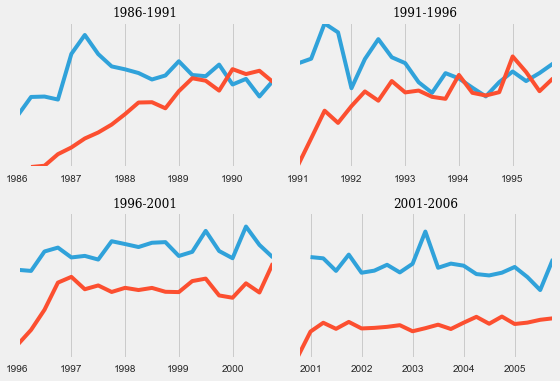

In [586]:
fig = plt.figure()

axeslist = [ax1,ax2,ax3,ax4]

ax1 = fig.add_subplot(221)
(comb[1986].set_index('date').resample('Q')['Topic5']*65).plot(ax=ax1)
(pmdf_subset[1986].set_index('date').resample('Q')['scaled']).plot(ax=ax1)
ax1.set_title("1986-1991", fontdict=font4)
ax1.axes.get_yaxis().set_ticks([])
ax1.set_xlabel("")

ax2 = fig.add_subplot(222)
(comb[1991].set_index('date').resample('Q')['Topic55']*80).plot(ax=ax2)
(pmdf_subset[1991].set_index('date').resample('Q')['scaled']).plot(ax=ax2)
ax2.set_title("1991-1996", fontdict=font4)
ax2.axes.get_yaxis().set_ticks([])
ax2.set_xlabel("")

ax3 = fig.add_subplot(223)
(comb[1996].set_index('date').resample('Q')['Topic47']*60).plot(ax=ax3)
(pmdf_subset[1996].set_index('date').resample('Q')['scaled']).plot(ax=ax3)
ax3.set_title("1996-2001", fontdict=font4)
ax3.axes.get_yaxis().set_ticks([])
ax3.set_xlabel("")

ax4 = fig.add_subplot(224)
(comb[2001].set_index('date').resample('Q')['Topic3']*40).plot(ax=ax4)
(pmdf_subset[2001].set_index('date').resample('Q')['scaled']).plot(ax=ax4)
ax4.set_title("2001-2006",fontdict=font4)
ax4.axes.get_yaxis().set_ticks([])
ax4.set_xlabel("")

#plt.suptitle('AIDs - LDA Topic Modeling and PubMed Article Publication Frequency', fontdict=font4)
plt.tight_layout()

The next sequence of plots highlight events of interest that appeared in LDA topic modeling. Rather than being consistent throughout datasets, these events ocurred uniquely within a certain 4 year interval and reflected a very specific circumstance that dominated series of New York Times articles. We identified these topics in the topic check, and then plotted them with the expectation that the topic would "spike" during its actual ocurrence, and then trail off in interest afterwards. As before, the Y axis represents LDA topic probabilities for articles averaged within date quartiles, and the X axis is the date quartiles. 

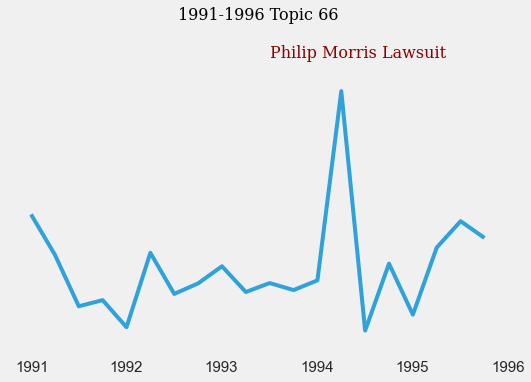

In [263]:
with plt.style.context('fivethirtyeight'):
    plot = comb[1991].set_index('date').resample('Q')['Topic66'].plot()
    plot.set_ylim(0.008,0.018)
    plot.set_xlim(pd.to_datetime('1990-12-1'),pd.to_datetime('1996-1-1'))
    plot.text(pd.to_datetime('1993-7-20'), 0.017, "Philip Morris Lawsuit", fontdict=font)
    plot.set_title("1991-1996 Topic 66", fontdict=font2)
    plot.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    plot.axes.get_yaxis().set_ticks([]) # remove yticks
    plot.set_xlabel("") # remove xlabel
    plot.grid(False) # remove grid

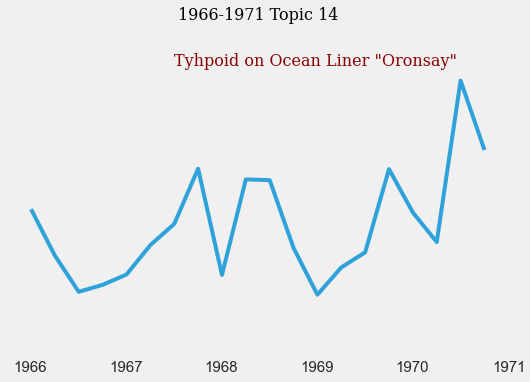

In [313]:
with plt.style.context('fivethirtyeight'):
    plot = comb[1966].set_index('date').resample('Q')['Topic14'].plot()
    plot.set_ylim(0.008,0.020)
    plot.set_xlim(pd.to_datetime('1965-12-1'),pd.to_datetime('1971-1-1'))
    plot.text(pd.to_datetime('1967-7-20'), 0.0185, 'Tyhpoid on Ocean Liner "Oronsay"', fontdict=font)
    plot.set_title("1966-1971 Topic 14", fontdict=font2)
    plot.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    plot.axes.get_yaxis().set_ticks([]) # remove yticks
    plot.set_xlabel("") # remove xlabel
    plot.grid(False) # remove grid

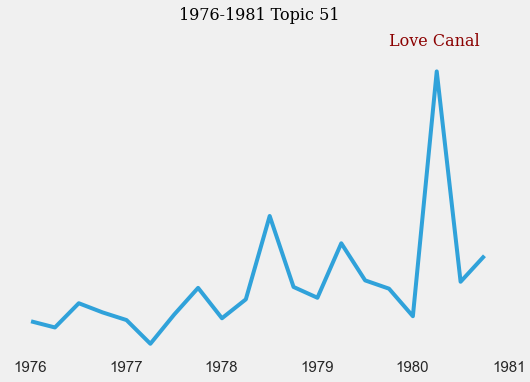

In [278]:
with plt.style.context('fivethirtyeight'):
    plot = comb[1976].set_index('date').resample('Q')['Topic51'].plot()
    plot.set_ylim(0.008,0.024)
    plot.set_xlim(pd.to_datetime('1975-12-1'),pd.to_datetime('1981-1-1'))
    plot.text(pd.to_datetime('1979-12-20'), 0.023, "Love Canal", fontdict=font)
    plot.set_title("1976-1981 Topic 51", fontdict=font2)
    plot.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    plot.axes.get_yaxis().set_ticks([]) # remove yticks
    plot.set_xlabel("") # remove xlabel
    plot.grid(False) # remove grid

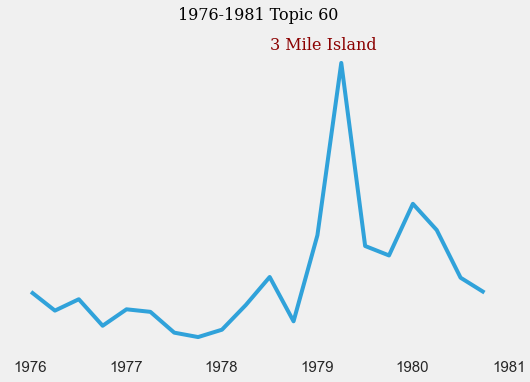

In [282]:
with plt.style.context('fivethirtyeight'):
    plot = comb[1976].set_index('date').resample('Q')['Topic60'].plot()
    plot.set_ylim(0.010,0.037)
    plot.set_xlim(pd.to_datetime('1975-12-1'),pd.to_datetime('1981-1-1'))
    plot.text(pd.to_datetime('1978-7-20'), 0.035, "3 Mile Island", fontdict=font)
    plot.set_title("1976-1981 Topic 60", fontdict=font2)
    plot.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    plot.axes.get_yaxis().set_ticks([]) # remove yticks
    plot.set_xlabel("") # remove xlabel
    plot.grid(False) # remove grid

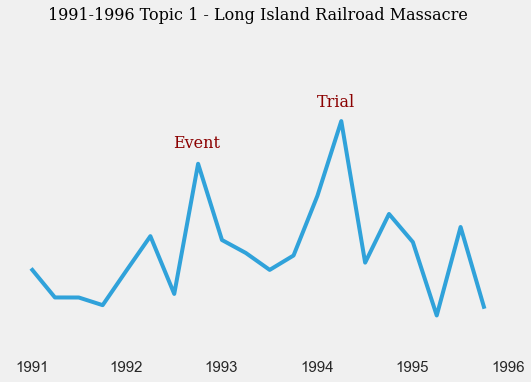

In [286]:
with plt.style.context('fivethirtyeight'):
    plot = comb[1991].set_index('date').resample('Q')['Topic1'].plot()
    plot.set_ylim(0.008,0.016)
    plot.set_xlim(pd.to_datetime('1990-12-1'),pd.to_datetime('1996-1-1'))
    plot.text(pd.to_datetime('1992-7-20'), 0.013, "Event", fontdict=font)
    plot.text(pd.to_datetime('1994-3-20'), 0.014, "Trial", fontdict=font)
    plot.set_title("1991-1996 Topic 1 - Long Island Railroad Massacre", fontdict=font2)
    plot.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    plot.axes.get_yaxis().set_ticks([]) # remove yticks
    plot.set_xlabel("") # remove xlabel
    plot.grid(False) # remove grid

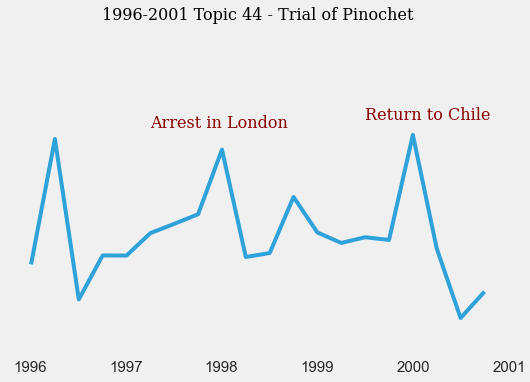

In [292]:
with plt.style.context('fivethirtyeight'):
    plot = comb[1996].set_index('date').resample('Q')['Topic44'].plot()
    plot.set_ylim(0.007,0.015)
    plot.set_xlim(pd.to_datetime('1995-12-1'),pd.to_datetime('2001-1-1'))
    plot.text(pd.to_datetime('1997-5-20'), 0.0125, "Arrest in London", fontdict=font)
    plot.text(pd.to_datetime('1999-7-20'), 0.0127, "Return to Chile", fontdict=font)
    plot.set_title("1996-2001 Topic 44 - Trial of Pinochet", fontdict=font2)
    plot.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    plot.axes.get_yaxis().set_ticks([]) # remove yticks
    plot.set_xlabel("") # remove xlabel
    plot.grid(False) # remove grid

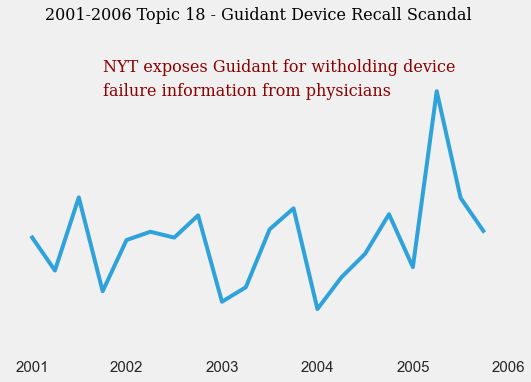

In [307]:
with plt.style.context('fivethirtyeight'):
    plot = comb[2001].set_index('date').resample('Q')['Topic18'].plot()
    plot.set_ylim(0.007,0.014)
    plot.set_xlim(pd.to_datetime('2000-12-1'),pd.to_datetime('2006-1-1'))
    plot.text(pd.to_datetime('2001-10-20'), 0.013, 
              "NYT exposes Guidant for witholding device", fontdict=font)
    plot.text(pd.to_datetime('2001-10-20'), 0.0125, 
              "failure information from physicians", fontdict=font)
    plot.set_title("2001-2006 Topic 18 - Guidant Device Recall Scandal", fontdict=font2)
    plot.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    plot.axes.get_yaxis().set_ticks([]) # remove yticks
    plot.set_xlabel("") # remove xlabel
    plot.grid(False) # remove grid

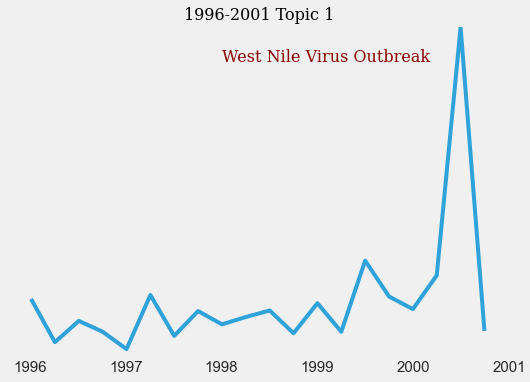

In [376]:
with plt.style.context('fivethirtyeight'):
    plot = comb[1996].set_index('date').resample('Q')['Topic1'].plot()
    plot.set_ylim(0.01,0.019)
    plot.set_xlim(pd.to_datetime('1995-12-1'),pd.to_datetime('2001-1-1'))
    plot.text(pd.to_datetime('1998-1-1'), 0.018, "West Nile Virus Outbreak", fontdict=font)
    plot.set_title("1996-2001 Topic 1", fontdict=font2)
    plot.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    plot.axes.get_yaxis().set_ticks([]) # remove yticks
    plot.set_xlabel("") # remove xlabel
    plot.grid(False) # remove grid

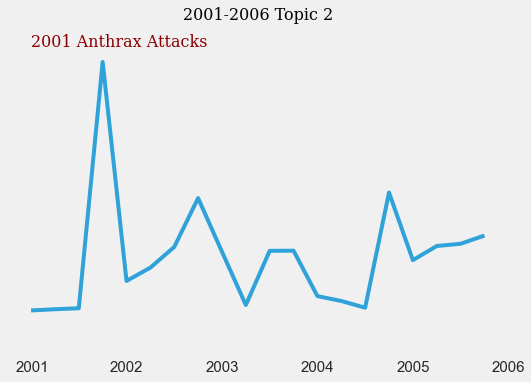

In [388]:
with plt.style.context('fivethirtyeight'):
    plot = comb[2001].set_index('date').resample('Q')['Topic2'].plot()
    plot.set_ylim(0.012,0.027)
    plot.set_xlim(pd.to_datetime('2000-12-1'),pd.to_datetime('2006-1-1'))
    plot.text(pd.to_datetime('2001-1-1'), 0.026, "2001 Anthrax Attacks", fontdict=font)
    plot.set_title("2001-2006 Topic 2", fontdict=font2)
    plot.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    plot.axes.get_yaxis().set_ticks([]) # remove yticks
    plot.set_xlabel("") # remove xlabel
    plot.grid(False) # remove grid

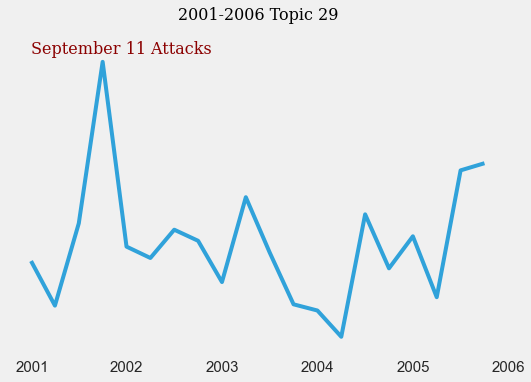

In [393]:
with plt.style.context('fivethirtyeight'):
    plot = comb[2001].set_index('date').resample('Q')['Topic29'].plot()
    plot.set_ylim(0.023,0.046)
    plot.set_xlim(pd.to_datetime('2000-12-1'),pd.to_datetime('2006-1-1'))
    plot.text(pd.to_datetime('2001-1-1'), 0.044, "September 11 Attacks", fontdict=font)
    plot.set_title("2001-2006 Topic 29", fontdict=font2)
    plot.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    plot.axes.get_yaxis().set_ticks([]) # remove yticks
    plot.set_xlabel("") # remove xlabel
    plot.grid(False) # remove grid

### Cosistent

We also attempted to plot topics which were consistent across time frames, though comparison was difficult as oftentimes one or two time frames did not identify the topic during LDA. For example, women's health was a consistent topic in many time frames (i.e. abortion in the 70s, breast cancer in recent years), though it was less pervasive in the 80s (compared to other topics identified by LDA). In addition, as we used variable number of topics for different time frames, topic probabilities had to be weighted in order to show trends across all time on a single plot. Specifically, we multiplied the probabilities by number of topics - providing greater weight to topics identified among many topics. For example, women's health in 1991 contained specific, relatable attributes that informed our labeling, while women's health in 2011 appealed to a broader definition. Due to time constraints on the project, we did not investigate more robust weighting techniques than demonstrated here. 

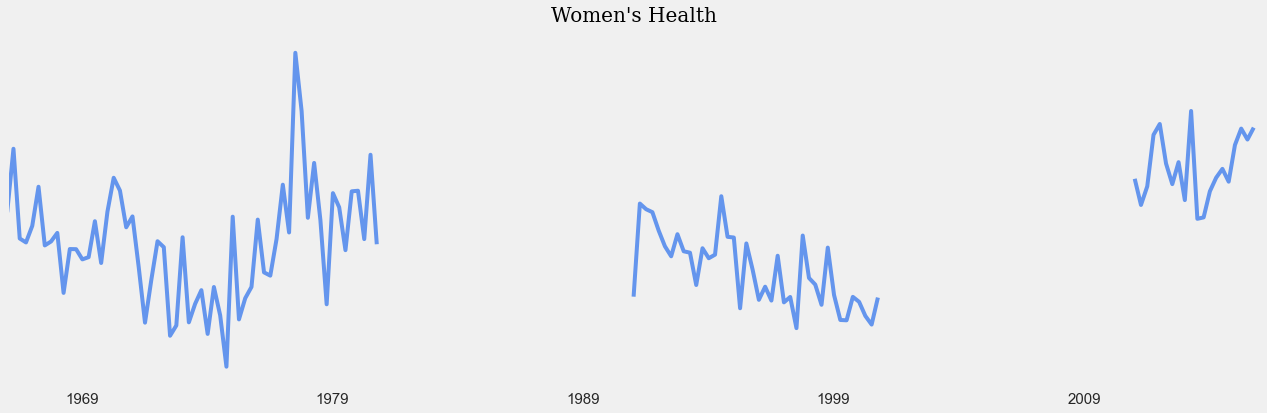

In [464]:
cont66 = comb[1966].set_index('date').resample('Q')['Topic13']*50
cont71 = comb[1971].set_index('date').resample('Q')['Topic28']*50
work = cont66.combine_first(cont71)
cont76 = comb[1976].set_index('date').resample('Q')['Topic31']*65
work = work.combine_first(cont76)

cont91 = comb[1991].set_index('date').resample('Q')['Topic4']*80
cont96 = comb[1996].set_index('date').resample('Q')['Topic50']*60
work2 = cont91.combine_first(cont96)

cont11 = comb[2011].set_index('date').resample('Q')['Topic11']*40

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(20,6))
    work2.plot(color='cornflowerblue')
    cont11.plot(color='cornflowerblue')
    nyt = work.plot(color='cornflowerblue', label='NYT LDA Topic Model Probability')
    nyt.set_title("Women's Health", fontdict=font3)
    nyt.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    nyt.set_xlim(pd.to_datetime("1966-1-1"),pd.to_datetime("2016-1-1"))
    nyt.axes.get_yaxis().set_ticks([]) # remove yticks
    nyt.set_xlabel("") # remove xlabel
    nyt.grid(False) # remove grid

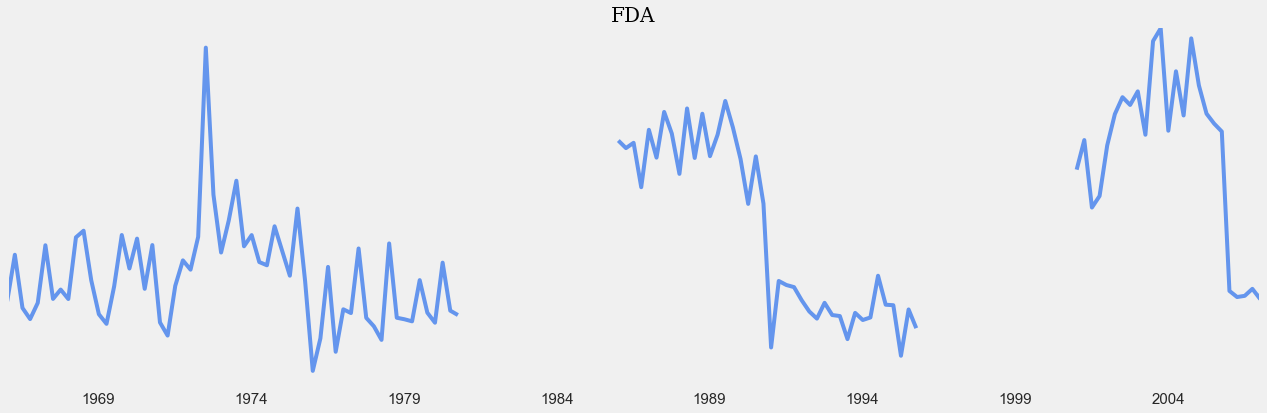

In [462]:
cont66 = comb[1966].set_index('date').resample('Q')['Topic33']*50
cont71 = comb[1971].set_index('date').resample('Q')['Topic7']*50
work = cont66.combine_first(cont71)
cont76 = comb[1976].set_index('date').resample('Q')['Topic37']*65
work = work.combine_first(cont76)

cont86 = comb[1986].set_index('date').resample('Q')['Topic9']*65
cont91 = comb[1991].set_index('date').resample('Q')['Topic4']*80
work2 = cont86.combine_first(cont91)

cont01 = comb[2001].set_index('date').resample('Q')['Topic12']*40
cont06 = comb[2006].set_index('date').resample('Q')['Topic10']*45
work3 = cont01.combine_first(cont06)

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(20,6))
    work2.plot(color='cornflowerblue')
    work3.plot(color='cornflowerblue')
    nyt = work.plot(color='cornflowerblue', label='NYT LDA Topic Model Probability')
    nyt.set_title("FDA", fontdict=font3)
    nyt.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    nyt.set_xlim(pd.to_datetime("1966-1-1"),pd.to_datetime("2007-1-1"))
    nyt.axes.get_yaxis().set_ticks([]) # remove yticks
    nyt.set_xlabel("") # remove xlabel
    nyt.grid(False) # remove grid

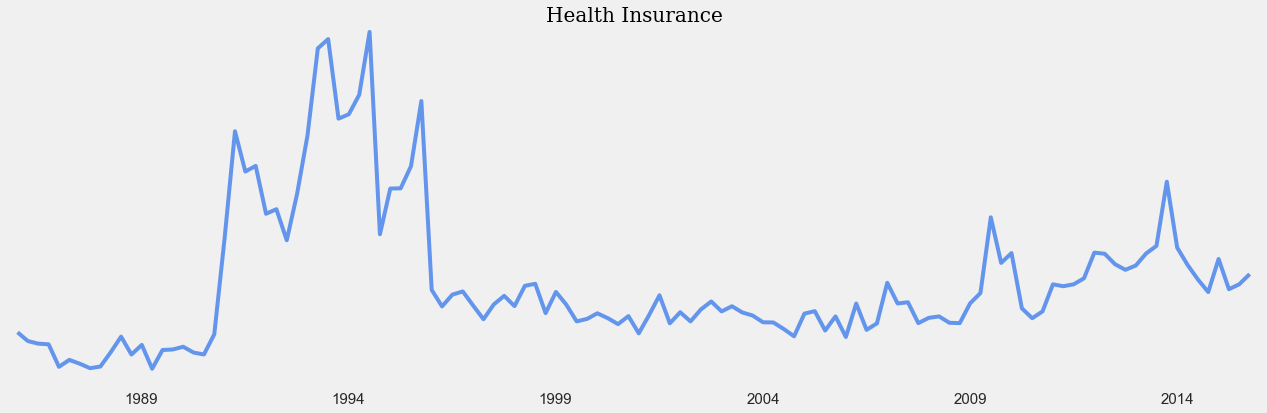

In [465]:
cont86 = comb[1986].set_index('date').resample('Q')['Topic38']*65
cont91 = comb[1991].set_index('date').resample('Q')['Topic68']*81
work = cont86.combine_first(cont91)
cont96 = comb[1996].set_index('date').resample('Q')['Topic20']*60
work = work.combine_first(cont96)
cont01 = comb[2001].set_index('date').resample('Q')['Topic19']*40
work = work.combine_first(cont01)
cont06 = comb[2006].set_index('date').resample('Q')['Topic37']*45
work = work.combine_first(cont06)
cont11 = comb[2011].set_index('date').resample('Q')['Topic21']*40
work = work.combine_first(cont11)

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(20,6))
    nyt = work.plot(color='cornflowerblue',label='NYT LDA Topic Model Probability')
    nyt.set_title("Health Insurance", fontdict=font3)
    nyt.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    nyt.set_xlim(pd.to_datetime("1985-12-31"),pd.to_datetime("2016-1-1"))
    nyt.axes.get_yaxis().set_ticks([]) # remove yticks
    nyt.set_xlabel("") # remove xlabel
    nyt.grid(False) # remove grid

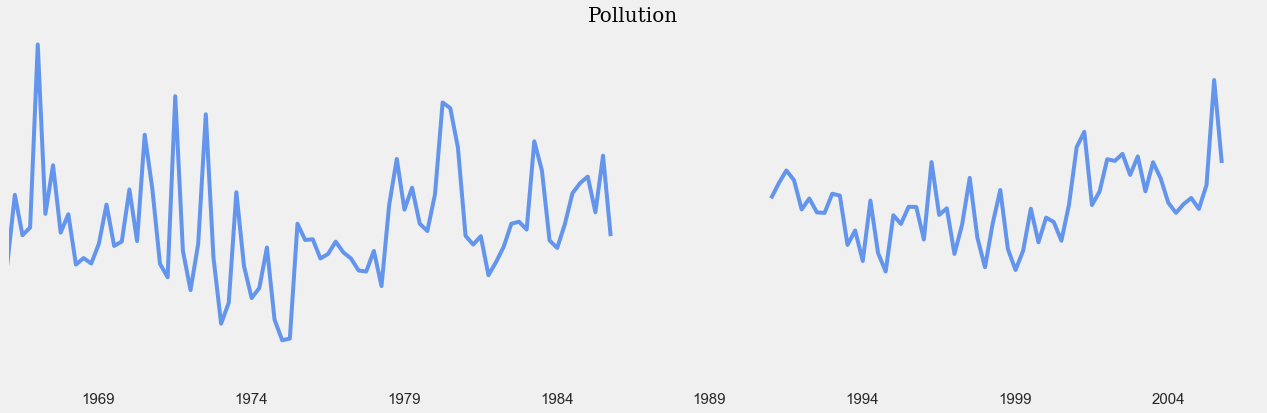

In [420]:
cont66 = comb[1966].set_index('date').resample('Q')['Topic41']*50
cont71 = comb[1971].set_index('date').resample('Q')['Topic20']*50
work = cont66.combine_first(cont71)
cont76 = comb[1976].set_index('date').resample('Q')['Topic25']*65
work = work.combine_first(cont76)
cont81 = comb[1981].set_index('date').resample('Q')['Topic16']*25
work = work.combine_first(cont81)
#cont86 = comb[1986].set_index('date').resample('Q')['Topic9']*65
#work = work.combine_first(cont86)
cont91 = comb[1991].set_index('date').resample('Q')['Topic13']*80
cont96 = comb[1996].set_index('date').resample('Q')['Topic39']*60
work2 = cont91.combine_first(cont96)
cont01 = comb[2001].set_index('date').resample('Q')['Topic31']*40
work2 = work2.combine_first(cont01)
#cont06 = comb[2006].set_index('date').resample('Q')['Topic10']*45
#work = work.combine_first(cont06)
#cont11 = comb[2011].set_index('date').resample('Q')['Topic21']*40
#work = work.combine_first(cont11)

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(20,6))
    work2.plot(color='cornflowerblue')
    nyt = work.plot(color='cornflowerblue',label='NYT LDA Topic Model Probability')
    nyt.set_title("Pollution", fontdict=font3)
    nyt.tick_params(axis='both', which='major', labelsize=15) # increase xlabel fontsize
    nyt.set_xlim(pd.to_datetime("1966-1-1"),pd.to_datetime("2007-1-1"))
    nyt.axes.get_yaxis().set_ticks([]) # remove yticks
    nyt.set_xlabel("") # remove xlabel
    nyt.grid(False) # remove grid

### Wordcloud logo for website

In [424]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

In [455]:
# read the mask image taken from https://www.nytimes.com
nyt_mask = np.array(Image.open("/Users/Luke/Documents/cs109/project/the-new-york-times.jpg"))

In [458]:
wc = WordCloud(background_color="black", max_words=2000, mask=nyt_mask,
               stopwords=STOPWORDS)

In [430]:
with open("/Users/Luke/Documents/cs109/project/parseout1981.txt", 'r') as f:
    parseout1986 = json.load(f)

In [434]:
import itertools
document1986 = list(itertools.chain.from_iterable(parseout1986))
document1986 = ' '.join(document1986)

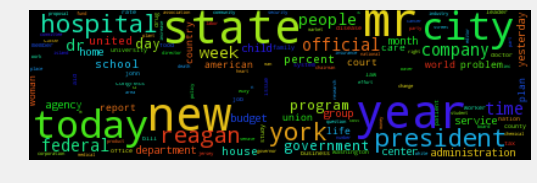

In [459]:
# generate word cloud
wc.generate(document1986)
# show
plt.imshow(wc)
plt.axis("off")
plt.figure()
#plt.imshow(nyt_mask, cmap=plt.cm.gray)
#plt.axis("off")
plt.show()

### Topic bubbles

We explored altnerative visualization techniques in the following diagrams. As before, we selected topics of interest based on the clarity they provided in the labeling process, and whether they fell under the broad umbrella of public health. We calculated the mean of a topic within a certain dataframe (i.e., the topic probability from LDA averaged over all documents, weighted by the number of topics generated for that dataframe), and used the mean to inform font size of the respective topic label. The number of topics for each time frame was not fixed, rather it varied by however many topics of interest we could fined. 

In [587]:
topicdict = {'Birth Control': np.mean(comb[1966]['Topic13']),
            'Hospitals': np.mean(comb[1966]['Topic30']),
            'Pollution': np.mean(comb[1966]['Topic41']),
            'Smoking': np.mean(comb[1966]['Topic49']),
            'FDA': np.mean(comb[1966]['Topic33']),
            'Medicare': np.mean(comb[1966]['Topic24']),
            'Health Research': np.mean(comb[1966]['Topic19']),
            'Heart Disease': np.mean(comb[1966]['Topic5']),
            'Community Health': np.mean(comb[1966]['Topic27']),
            'Typhoid': np.mean(comb[1966]['Topic14'])
            }
topicdict1 = {'Patients': np.mean(comb[1971]['Topic0']),
              'Heart Disease': np.mean(comb[1971]['Topic3']),
              'Family Health': np.mean(comb[1971]['Topic5']),
              'FDA': np.mean(comb[1971]['Topic7']),
              'Cancer': np.mean(comb[1971]['Topic8']),
              'Pollution': np.mean(comb[1971]['Topic20']),
              'Disasters': np.mean(comb[1971]['Topic23']),
              'Drug Abuse': np.mean(comb[1971]['Topic25']),
              "Women's Health": np.mean(comb[1971]['Topic28']),
              'Hospitals': np.mean(comb[1971]['Topic37']),
              'Epidemics': np.mean(comb[1971]['Topic48'])
             }
topicdict2 = {'Child Health': np.mean(comb[1976]['Topic10']),
              'Health Risks': np.mean(comb[1976]['Topic11']),
              'Energy': np.mean(comb[1976]['Topic17']),
              'International Disease': np.mean(comb[1976]['Topic19']),
              'Pollution': np.mean(comb[1976]['Topic20']),
              'Environment': np.mean(comb[1976]['Topic25']),
              "Abortion": np.mean(comb[1976]['Topic31']),
              'Cancer': np.mean(comb[1976]['Topic38']),
              'Doctors': np.mean(comb[1976]['Topic55']),
              'Hospitals': np.mean(comb[1976]['Topic58']),
              'Heart Disease': np.mean(comb[1976]['Topic63'])
             }
topicdict3 = {'Health Research': np.mean(comb[1981]['Topic4']),
              'Chemical Plant': np.mean(comb[1981]['Topic16']),
              'Chronic Disease': np.mean(comb[1981]['Topic22']),
              'Sports Injuries': np.mean(comb[1981]['Topic8'])
              #'General Interest': np.mean(comb[1981]['Topic21'])
             }
topicdict4 = {'Hospitals': np.mean(comb[1986]['Topic42']),
              'AIDs': np.mean(comb[1986]['Topic5']),
              'FDA': np.mean(comb[1986]['Topic9']),
              'Women': np.mean(comb[1986]['Topic10']),
              #'Dangers': np.mean(comb[1986]['Topic36']),
              'Environment': np.mean(comb[1986]['Topic17']),
              'Legislation': np.mean(comb[1986]['Topic24']),
              'Cancer': np.mean(comb[1986]['Topic27']),
              'Healthcare': np.mean(comb[1986]['Topic45']),
              'Homeless': np.mean(comb[1986]['Topic48']),
              'Childcare': np.mean(comb[1986]['Topic58']),
              'Job Safety': np.mean(comb[1986]['Topic61'])
              }
topicdict5 = {'CDC': np.mean(comb[1991]['Topic3']),
              'Abortion': np.mean(comb[1991]['Topic4']),
              'Sports': np.mean(comb[1991]['Topic5']),
              'Hospitals': np.mean(comb[1991]['Topic6']),
              'Pollution': np.mean(comb[1991]['Topic13']),
              'Children': np.mean(comb[1991]['Topic30']),
              "Women's Health": np.mean(comb[1991]['Topic60']),
              'AIDs': np.mean(comb[1991]['Topic55']),
              'FDA': np.mean(comb[1991]['Topic63']),
              'Cigarettes': np.mean(comb[1991]['Topic66']),
              'Medical Research': np.mean(comb[1991]['Topic74']),
              'Vaccines': np.mean(comb[1991]['Topic75']),
              'Patients': np.mean(comb[1991]['Topic76']),
              'Health Insurance': np.mean(comb[1991]['Topic68'])
              }
topicdict6 = {'Outbreak': np.mean(comb[1996]['Topic1']),
              'Hospitals': np.mean(comb[1996]['Topic7']),
              'Heart Research': np.mean(comb[1996]['Topic12']),
              'Cigarettes': np.mean(comb[1996]['Topic13']),
              'Family': np.mean(comb[1996]['Topic19']),
              'Health Insurance': np.mean(comb[1996]['Topic20']),
              "Poverty": np.mean(comb[1996]['Topic22']),
              'Prescription Drugs': np.mean(comb[1996]['Topic32']),
              'Chemical Plant': np.mean(comb[1996]['Topic39']),
              'Food': np.mean(comb[1996]['Topic42']),
              'Breast Cancer': np.mean(comb[1996]['Topic51']),
              'Children': np.mean(comb[1996]['Topic53'])
              }
topicdict7 = {'Research': np.mean(comb[2001]['Topic1']),
              'Anthrax': np.mean(comb[2001]['Topic2']),
              'Epidemics': np.mean(comb[2001]['Topic3']),
              'Sports Injuries': np.mean(comb[2001]['Topic7']),
              'FDA': np.mean(comb[2001]['Topic12']),
              'Hospitals': np.mean(comb[2001]['Topic15']),
              "Health Insurance": np.mean(comb[2001]['Topic19']),
              'Death': np.mean(comb[2001]['Topic28']),
              'Pollution': np.mean(comb[2001]['Topic31']),
              'Family': np.mean(comb[2001]['Topic34']),
              'Chronic Disease': np.mean(comb[2001]['Topic39'])
             }
topicdict8 = {'Gas': np.mean(comb[2006]['Topic6']),
              'Fitness': np.mean(comb[2006]['Topic9']),
              'FDA': np.mean(comb[2006]['Topic10']),
              'Hospitals': np.mean(comb[2006]['Topic11']),
              'Safety': np.mean(comb[2006]['Topic16']),
              'ACA': np.mean(comb[2006]['Topic20']),
              "Swine Flu": np.mean(comb[2006]['Topic34']),
              'Health Inusrance': np.mean(comb[2006]['Topic37']),
              'Hurricane Katrina': np.mean(comb[2006]['Topic38']),
              'Doctors': np.mean(comb[2006]['Topic41']),
              'Prescription Drugs': np.mean(comb[2006]['Topic40']),
              'Children': np.mean(comb[2006]['Topic42'])
              }
topicdict9 = {'Bird Flu': np.mean(comb[2011]['Topic0']),
              'Ebola': np.mean(comb[2011]['Topic2']),
              #'Workers': np.mean(comb[2011]['Topic6']),
              'Safety': np.mean(comb[2011]['Topic7']),
              'Breast Cancer': np.mean(comb[2011]['Topic11']),
              'Abortion': np.mean(comb[2011]['Topic13']),
              "Health Insurance": np.mean(comb[2011]['Topic21']),
              'Outbreak': np.mean(comb[2011]['Topic26']),
              'Terrorist': np.mean(comb[2011]['Topic31']),
              'Researchers': np.mean(comb[2011]['Topic32'])
              #'Jobs': np.mean(comb[2011]['Topic18'])
             }
td0 = pd.DataFrame(topicdict.items(), columns=['Topics', 'Means'])
td1 = pd.DataFrame(topicdict1.items(), columns=['Topics', 'Means'])
td2 = pd.DataFrame(topicdict2.items(), columns=['Topics', 'Means'])
td3 = pd.DataFrame(topicdict3.items(), columns=['Topics', 'Means'])
td4 = pd.DataFrame(topicdict4.items(), columns=['Topics', 'Means'])
td5 = pd.DataFrame(topicdict5.items(), columns=['Topics', 'Means'])
td6 = pd.DataFrame(topicdict6.items(), columns=['Topics', 'Means'])
td7 = pd.DataFrame(topicdict7.items(), columns=['Topics', 'Means'])
td8 = pd.DataFrame(topicdict8.items(), columns=['Topics', 'Means'])
td9 = pd.DataFrame(topicdict9.items(), columns=['Topics', 'Means'])

In [588]:
tds = [td0,td1,td2,td3,td4,td5,td6,td7,td8,td9]
weights = [50,50,65,25,65,80,60,40,45,40]
tdss = []
for i, td in enumerate(tds):
    td.Means = td.Means*weights[i]
    tdss.append(td.sort('Means', ascending=False).reset_index())

/Users/Luke/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [589]:
tdss[0]

,index,Topics,Means
0,3,Smoking,1.248606
1,8,Hospitals,1.143690
2,0,FDA,1.012829
3,7,Heart Disease,0.999781
4,5,Birth Control,0.942402
5,1,Community Health,0.888620
6,6,Health Research,0.875971
7,2,Medicare,0.816012
8,9,Pollution,0.789936
9,4,Typhoid,0.633999


In [590]:
years = range(1966,2016,5)
years

[1966, 1971, 1976, 1981, 1986, 1991, 1996, 2001, 2006, 2011]

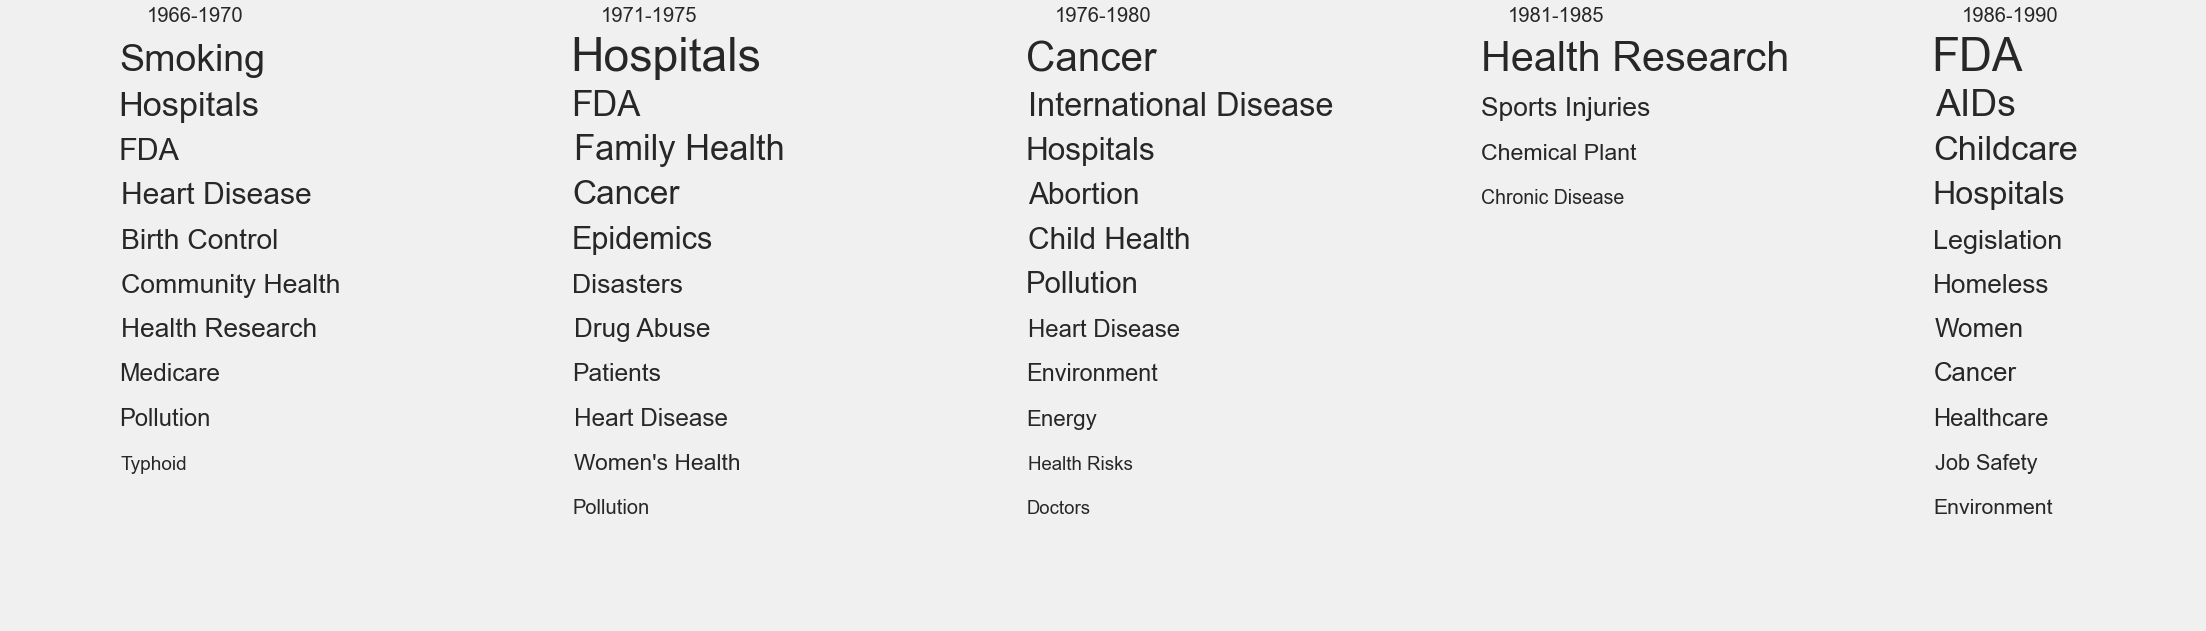

In [591]:
plt.figure(figsize=(35,10))
for i in range(5):
    td = tdss[i]
    plt.subplot(1,5,i+1)
    plt.ylim(0,13+0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(years[i])+'-'+str(years[i]+4))
    for index, row in td.iterrows():
        plt.text(0.3, 13-index-0.5, row.Topics, fontsize=row.Means*30)
plt.grid(False)
plt.show()

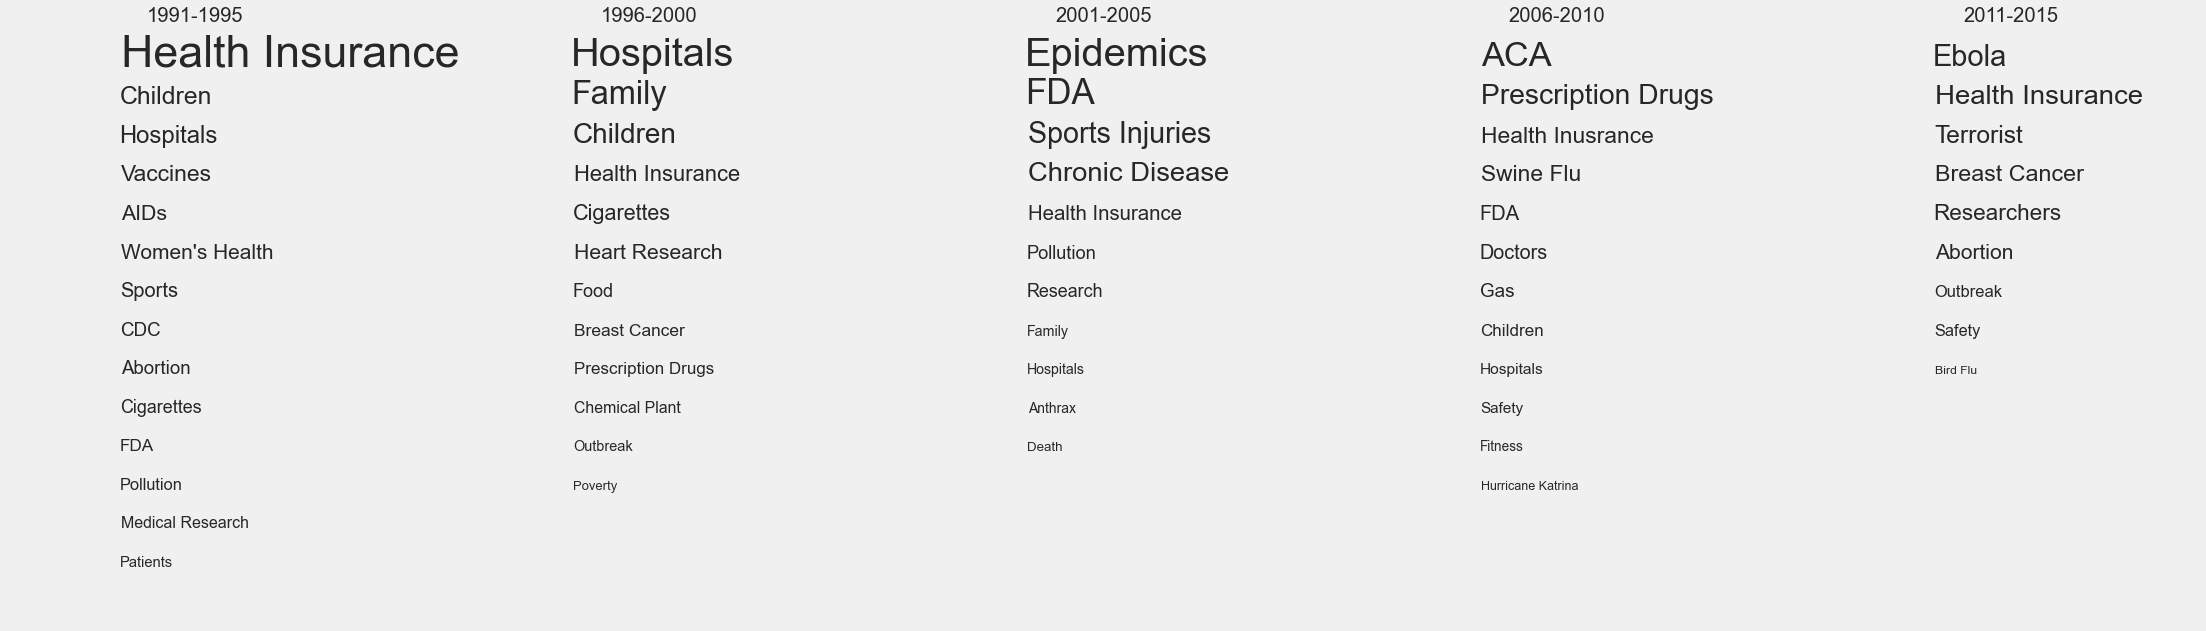

In [592]:
plt.figure(figsize=(35,10))
for i in range(5):
    td = tdss[i+5]
    plt.subplot(1,5,i+1)
    plt.ylim(0,15+0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(years[i+5])+'-'+str(years[i+5]+4))
    for index, row in td.iterrows():
        plt.text(0.3, 15-index-0.5, row.Topics, fontsize=row.Means*21)
plt.grid(False)
plt.show()